<a href="https://colab.research.google.com/github/cottissimo/hhanal/blob/main/hhanal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HeadHunter vacances parser

### Step 1. Specify search parameters for HeadHunter API

In [ ]:
# List of different job titles for search vacancies
job_titles = [
    'product manager',
    'менеджер продуктов',
    'менеджер продукта',
    'product owner',
    'владелец продукта',
    'руководитель продукта',
    'product lead'
]

# Dictionary for sinonyms
skills_synonyms = {
    'Менеджер продуктов': 'Product manager',
    'Менеджер продутка': 'Product manager',
    'Владелец продукта': 'Product Owner'
}

# https://api.hh.ru/specializations
specialization_ids = '1'

### Step 2. Import required libraries

In [ ]:
import requests
import json
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
from tqdm import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta

### Step 3. Define simple Class with methods for parsing

In [ ]:
class Parser(object):

    def __init__(self, job_titles, skills_synonyms, specialization_ids):

        # HH Endpoint
        self.__url = 'https://api.hh.ru'

        # Range of dates for search vacancies
        self.__dt_from = (datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d')
        self.__dt_to = datetime.today().strftime('%Y-%m-%d')

        # Types of experiences
        self.__experience = ['noExperience', 'between1And3', 'between3And6', 'moreThan6']

        self.__job_titles = job_titles
        self.__skills_synonyms = skills_synonyms
        self.__specialization_ids = specialization_ids


    # Private methods

    def _get_vacancies_params(self, text, experience, page=0, per_page=100) -> dict:
        '''Returns params in dictionary for GET /vacancies request
           https://github.com/hhru/api/blob/master/docs/vacancies.md
        '''

        params = {
            'text': text,
            'date_from': self.__dt_from,
            'date_to': self.__dt_to,
            'experience': experience,
            'page': page,
            'per_page': per_page,
            'currency': 'RUR',
            'responses_count_enabled': True,
            'premium': True
        }

        if self.__specialization_ids:
            params['specialization'] = self.__specialization_ids

        return params


    def _get_vacancies_text(self) -> str:
        ''' Returns correct format text param for GET /vacancies request
        '''

        job_titles = ' OR '.join([f'\'{str(e)}\'' for e in self.__job_titles])

        return f'NAME:({job_titles})'


    def _get_vacancies_req(self, params) -> dict:
        '''Wrapper for GET /vacancies API request
        '''

        r = requests.get(url = f'{self.__url}/vacancies', params = params)
        data = r.json()

        return data


    def _get_vacancy_by_id(self, id: int) -> dict:
        '''Wrapper for GET /vacancies/{vacancy_id} API request
        '''

        r = requests.get(url = f'{self.__url}/vacancies/{id}')
        data = r.json()

        return data


    def _get_items_id(self, items: list) -> list:

        return [item['id'] for item in items]


    # Public methods

    def get_vacancies(self) -> pd.DataFrame:
        '''Main function which returns DataFrame with vacancies
        '''

        df = pd.DataFrame()
        text = self._get_vacancies_text()

        for exp in self.__experience:
            print(f'\nFor Experience = \'{exp}\'')

            params = self._get_vacancies_params(text, exp)
            resp = self._get_vacancies_req(params)

            items_id = self._get_items_id(resp['items'])
            pages = resp['pages']

            # Send request for every page
            for page in tqdm(range(1, pages), position=0, desc='Step (1/2): page\'s process'):

                params = self._get_vacancies_params(text, exp, page)
                resp = self._get_vacancies_req(params)
                items_id += self._get_items_id(resp['items'])

            # Send request for every vacancy
            items = [self._get_vacancy_by_id(id) for id in tqdm(items_id, position=0, desc='Step (2/2): vacancies process')]

            df_items = pd.DataFrame(items)
            df_items['experience'] = exp

            df = pd.concat([df, df_items])

        return df

## Define simple Class for analyse vacancies

In [ ]:
class Analysis(object):

    def __init__(self, vacancies: pd.DataFrame):
        self.__vacancies = vacancies.copy()
        self._clean_vacancies()


    # Private methods

    def _convert_experience(self, exp: str) -> str:
        convert = {
            'noExperience': 'Junior (no experince)',
            'between1And3': 'Junior+ (1-3 years)',
            'between3And6': 'Middle (3-6 years)',
            'moreThan6': 'Senior (6+ years)',
        }

        if exp in convert:
            return convert[exp]
        else:
            return 'Other'


    def _convert_salary(self, salary) -> tuple:

        salary_from, salary_to = np.nan, np.nan

        if salary and salary['currency'] == 'RUR':
            salary_from = salary['from'] if salary['from'] != None else np.nan
            salary_to = salary['to'] if salary['to'] != None else np.nan

        return (salary_from, salary_to)


    def _calculate_freq(self, df: pd.DataFrame, max_size=20) -> tuple:

        if len(df) == 0:
            return (0, 0)

        skills_dict = {}

        for row in df.items():
            skills = row[1]
            for skill in skills:
                if skill in skills_dict:
                    skills_dict[skill] += 1
                else:
                    skills_dict[skill] = 1

        if len(skills_dict) < max_size:
            max_size = len(skills_dict)

        skills_dict = dict(sorted(skills_dict.items(), key=lambda item: item[1], reverse=True))

        return (list(skills_dict.keys())[:max_size][::-1],
                list(skills_dict.values())[:max_size][::-1])


    def _clean_vacancies(self):

        # choose right columns only
        self.__vacancies = self.__vacancies[['id', 'published_at', 'name', 'area',
                                             'salary', 'employer', 'type', 'experience',
                                             'description', 'key_skills', 'alternate_url',
                                             'schedule', 'employment', 'contacts']]

        self.__vacancies = self.__vacancies[self.__vacancies['id'].notna()]

        # convert 'area' json to string
        convert_area = lambda area: area['name'] if 'name' in area else np.nan
        self.__vacancies['area'] = self.__vacancies['area'].apply(convert_area).astype('string')

        # convert Employer name from json to strinng
        convert_employer = lambda employer: employer['name'] if 'name' in employer else np.nan
        self.__vacancies['employer'] = self.__vacancies['employer'].apply(convert_employer).astype('string')

        # convert 'key_skills' to list
        convert_skills = lambda skills: [skill['name'] if skill['name'] not in skills_synonyms
                                         else skills_synonyms[skill['name']] for skill in skills]
        self.__vacancies['key_skills'] = self.__vacancies['key_skills'].apply(convert_skills)

        # convert 'type' json to string
        convert_type = lambda tp: tp['name'] if 'name' in tp else np.nan
        self.__vacancies['type'] = self.__vacancies['type'].apply(convert_type).astype('string')

        # convert other fields
        self.__vacancies['id'] = self.__vacancies['id'].astype('int')
        self.__vacancies['published_at'] =  pd.to_datetime(self.__vacancies['published_at'],
                                                           format='%Y-%m-%dT%X%z')
        self.__vacancies['name'] = self.__vacancies['name'].astype('string')
        self.__vacancies['alternate_url'] = self.__vacancies['alternate_url'].astype('string')
        self.__vacancies['description_cleaned'] = self.__vacancies['description'].astype('string')

        # convert experience field to new format
        self.__vacancies['experience'] = self.__vacancies['experience'].apply(self._convert_experience).astype('string')


        # convert Salaris to RUR
        self.__vacancies['salary'] = self.__vacancies['salary'].apply(self._convert_salary)
        self.__vacancies[['salary_from', 'salary_to']] = pd.DataFrame(self.__vacancies['salary'].tolist(),
                                                                      index=self.__vacancies.index)
        self.__vacancies.drop(columns=['salary'], inplace=True)


        # convert 'schedule' json to string
        convert_schedule = lambda schedule: schedule['name'] if 'name' in schedule else np.nan
        self.__vacancies['schedule'] = self.__vacancies['schedule'].apply(convert_schedule).astype('string')


        # convert 'employment' json to string
        convert_employment = lambda employment: employment['name'] if 'name' in employment else np.nan
        self.__vacancies['employment'] = self.__vacancies['employment'].apply(convert_employment).astype('string')


    # Properties

    @property
    def vacancies_count(self):
        return len(self.__vacancies.index)


    # Public methods

    def get_vacancie(self, id: int):
        try:
            result = self.__vacancies.iloc[0]

        except Exception as e:
            result = f'{e}'

        return result


    def show_open_vacancies(self):

        df = self.__vacancies.groupby(['type']).size()
        print(df)


    def show_vacancies_with_contacts(self):

        wo_contacts_cnt = len(self.__vacancies[self.__vacancies['contacts'].isna()].index)
        w_contacts_cnt = len(self.__vacancies[self.__vacancies['contacts'].notna()].index)

        print(f'Vacancies with contacts: {wo_contacts_cnt}')
        print(f'Vacancies without contacts: {w_contacts_cnt}')


    def show_experience(self):

        df = self.__vacancies.groupby(['experience']).size()
        x = df.index.to_list()
        y = df.to_list()

        fig, axs = plt.subplots(1, 2, figsize=(20, 6))
        fig.suptitle('Number of vacancies in the context of experience', fontsize=14)

        axs[0].bar(x, y)
        axs[0].set_xlabel('Experience')
        axs[0].set_ylabel('Count')

        rects = axs[0].patches
        labels = df.to_list()

        for rect, label in zip(rects, labels):
            height = rect.get_height()
            axs[0].text(rect.get_x() + rect.get_width() / 2, height,
                        label, ha='center', va='bottom')

        patches, texts, pcts = axs[1].pie(y, labels=x, autopct='%.1f%%',
                                          textprops={'size': 'medium'}, startangle=90)


    def show_cities(self, count: int):

        sorted_10 = self.__vacancies.groupby(['area']).size() \
                        .sort_values(ascending=False)[:count]

        grouped = self.__vacancies[self.__vacancies['area'].isin(sorted_10.index.tolist())] \
                      .groupby(['area', 'experience']).size()

        grouped.reindex(index=sorted_10.index, level=0).unstack() \
               .plot(kind='bar', figsize=(20, 6), stacked=True)

        plt.title(f'TOP {count} cities with vacancies', fontsize=14, pad=20)
        plt.legend(['Jun+: 1-3 years', 'Mid: 3-6 years', 'Sr: 6+ years',
                    'Jun: without experience'], fontsize=12)
        plt.show()


    def show_skills(self):

        fig, axs = plt.subplots(3, 2, figsize=(20,15))

        # all vacancies
        x, y = self._calculate_freq(self.__vacancies['key_skills'])
        axs[0, 0].barh(x, y)
        axs[0, 0].set_title('All vacancies')

        # junior
        x, y = self._calculate_freq(self.__vacancies[self.__vacancies['experience'] == 'Junior (no experince)']['key_skills'])
        axs[1, 0].barh(x, y)
        axs[1, 0].set_title('Junior (no experince)')

        # junior+
        x, y = self._calculate_freq(self.__vacancies[self.__vacancies['experience'] == 'Junior+ (1-3 years)']['key_skills'])
        axs[1, 1].barh(x, y)
        axs[1, 1].set_title('Junior+ (1-3 years)')

        # middle
        x, y = self._calculate_freq(self.__vacancies[self.__vacancies['experience'] == 'Middle (3-6 years)']['key_skills'])
        axs[2, 0].barh(x, y)
        axs[2, 0].set_title('Middle (3-6 years)')

        # senior
        x, y = self._calculate_freq(self.__vacancies[self.__vacancies['experience'] == 'Senior (6+ years)']['key_skills'])
        axs[2, 1].barh(x, y)
        axs[2, 1].set_title('Senior (6+ years)')

        fig.tight_layout()


    def show_job_titles(self, count: int):

        x = self.__vacancies.groupby(['name']).size() \
                .sort_values(ascending=False)[:count].plot(kind='bar', figsize=(20, 6), stacked=True)

        plt.title(f'TOP {count} job titles', fontsize=14, pad=20)
        plt.show()


    def show_companies(self, count: int):

        sorted_5 = self.__vacancies.groupby(['employer']).size() \
                       .sort_values(ascending=False)[:count]

        grouped = self.__vacancies[self.__vacancies['employer'].isin(sorted_5.index.tolist())] \
                      .groupby(['employer', 'experience']).size()

        grouped.reindex(index=sorted_5.index, level=0).unstack() \
               .plot(kind='bar', figsize=(20, 6), stacked=True)

        plt.title(f'TOP {count} hunt compamies', fontsize=14, pad=20)
        plt.show()


    def show_shedule(self):

        sorted_5 = self.__vacancies.groupby(['schedule']).size().sort_values(ascending=False)
        grouped = self.__vacancies[self.__vacancies['schedule'].isin(sorted_5.index.tolist())] \
                      .groupby(['schedule', 'experience']).size()

        grouped.reindex(index=sorted_5.index, level=0).unstack() \
               .plot(kind='bar', figsize=(20, 6), stacked=True)

        plt.title(f'Remote work / not remote', fontsize=14, pad=20)
        plt.show()


    def show_employment(self):
        sorted_5 = self.__vacancies.groupby(['employment']).size().sort_values(ascending=False)
        grouped = self.__vacancies[self.__vacancies['employment'].isin(sorted_5.index.tolist())] \
                      .groupby(['employment', 'experience']).size()

        grouped.reindex(index=sorted_5.index, level=0).unstack() \
               .plot(kind='bar', figsize=(20, 6), stacked=True)

        plt.title(f'Employment', fontsize=14, pad=20)
        plt.show()


    def show_salary(self):

        df_with_salary = self.__vacancies[(~self.__vacancies['salary_from'].isnull()) | \
                                          (~self.__vacancies['salary_to'].isnull())]

        df_wo_salary = self.__vacancies[(self.__vacancies['salary_from'].isnull()) & \
                                        (self.__vacancies['salary_to'].isnull())]

        labels = ['With Salary', 'Without Salary']

        patches, texts, pcts = plt.pie([len(df_with_salary.index), len(df_wo_salary.index)],
                                       autopct='%.1f%%', textprops={'size': 'medium'},
                                       startangle=90, pctdistance=1.12, explode=[0.03, 0])

        plt.rcParams['figure.figsize'] = (20, 6)
        plt.title('Share of vacancies with a specified salary', fontsize=14, pad=20)
        plt.legend(labels=labels, loc='upper right', fontsize=12)

        plt.show()


    def show_salary_boxplot(self):

        df_with_salary = self.__vacancies[(~self.__vacancies['salary_from'].isnull()) | \
                                          (~self.__vacancies['salary_to'].isnull())]

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Junior (no experince)']
        s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
        jun_salary = s_tmp[~s_tmp.isnull()]

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Junior+ (1-3 years)']
        s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
        jun_plus_salary = s_tmp[~s_tmp.isnull()]

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Middle (3-6 years)']
        s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
        middle_salary = s_tmp[~s_tmp.isnull()]

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Senior (6+ years)']
        s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
        senior_salary = s_tmp[~s_tmp.isnull()]


        fig = plt.figure(figsize =(16, 6))
        ax = fig.add_axes([0, 0, 1, 1])

        labels = ['Junior (no experince)', 'Junior+ (1-3 years)',
                'Middle (3-6 years)', 'Senior (6+ years)']

        ax.boxplot([jun_salary, jun_plus_salary, middle_salary, senior_salary],
                labels=labels, vert=False)


    def download_csv(self):
        self.__vacancies.to_csv('vacancies.csv')
        files.download('vacancies.csv')

### Step 4. Run parsing and analyse vacancies

In [ ]:
# Parse vacancies
parser = Parser(job_titles, skills_synonyms, specialization_ids)
vacancies = parser.get_vacancies()


For Experience = 'noExperience'


Step (2/2): vacancies process: 100%|██████████| 371/371 [03:13<00:00,  1.91it/s]



For Experience = 'between1And3'


Step (2/2): vacancies process:  55%|█████▍    | 844/1548 [07:22<05:45,  2.04it/s]

ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [ ]:
# Initialise analysis object with vacancies
analysis = Analysis(vacancies)

print(f'Count of vacancies: {analysis.vacancies_count}\n')
print(f'Example:\n{analysis.get_vacancie(0)}')

Count of vacancies: 2806

Example:
id                                                             115135936
published_at                                   2025-01-09 12:19:15+03:00
name                                    Junior Product manager | iGaming
area                                                     Санкт-Петербург
employer                                                      TraffCloud
type                                                            Открытая
experience                                         Junior (no experince)
description            <p>TraffCloud — это международное digital-аген...
key_skills             [Asana, Start-up project, Бизнес-анализ, Roadm...
alternate_url                            https://hh.ru/vacancy/115135936
schedule                                                Удаленная работа
employment                                              Полная занятость
contacts                                                             NaN
description_clea

In [ ]:
analysis.show_open_vacancies()

type
Анонимная      11
Открытая     2795
dtype: int64


In [ ]:
analysis.show_vacancies_with_contacts()

Vacancies with contacts: 2806
Vacancies without contacts: 0


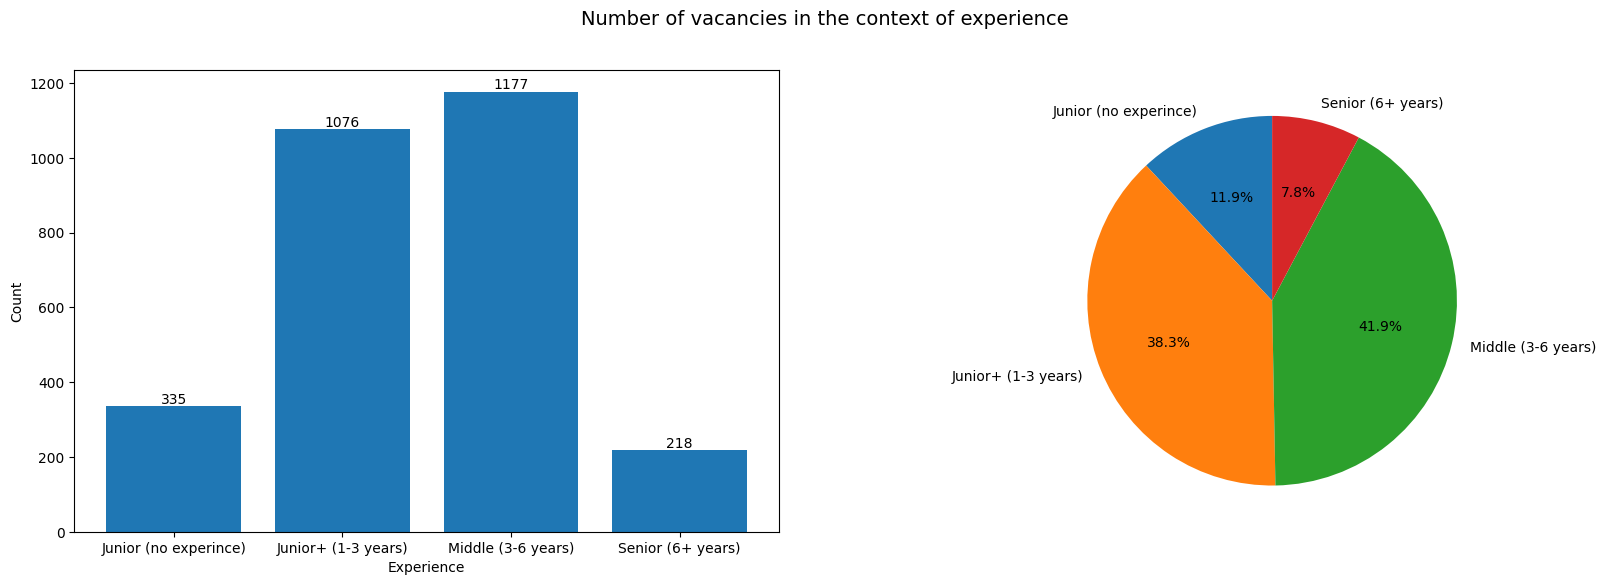

In [ ]:
analysis.show_experience()

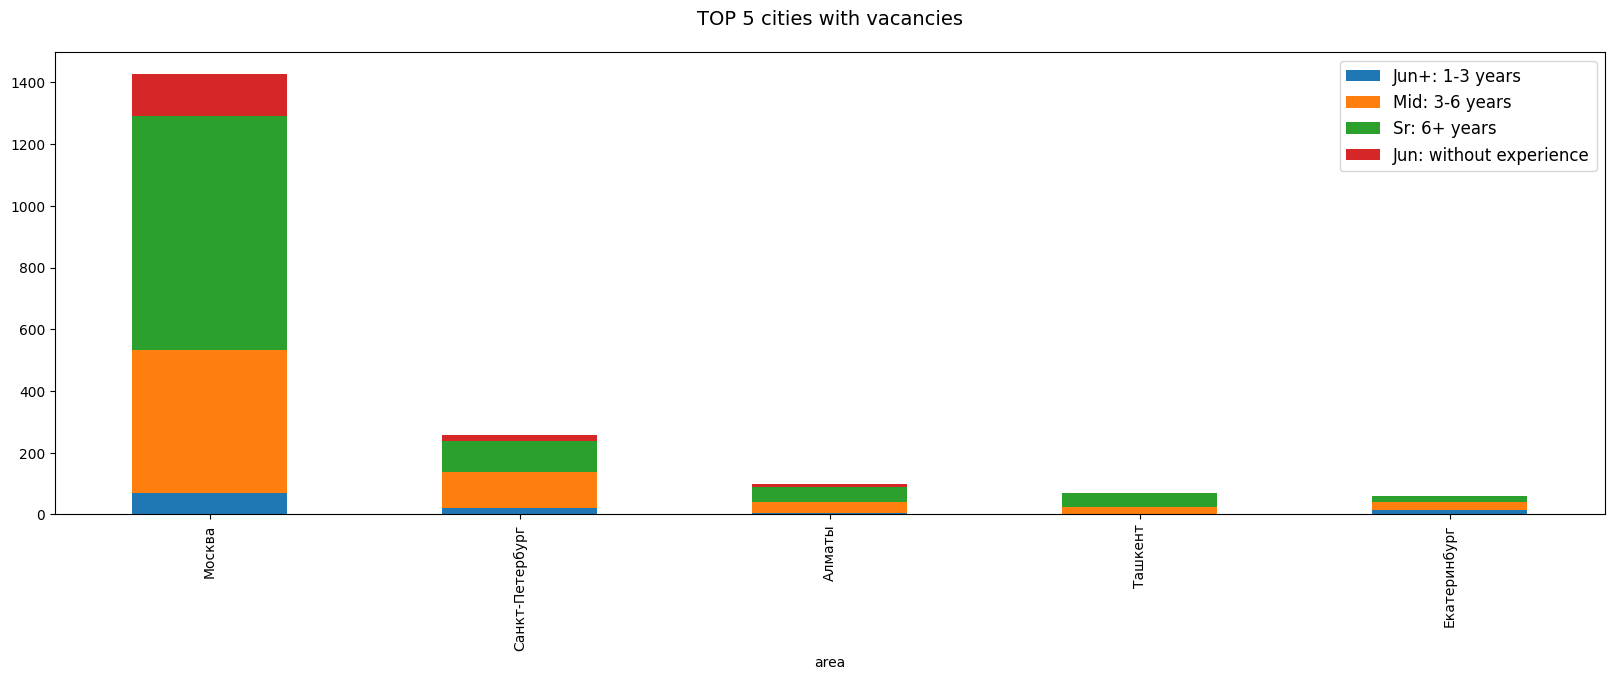

In [ ]:
analysis.show_cities(5)

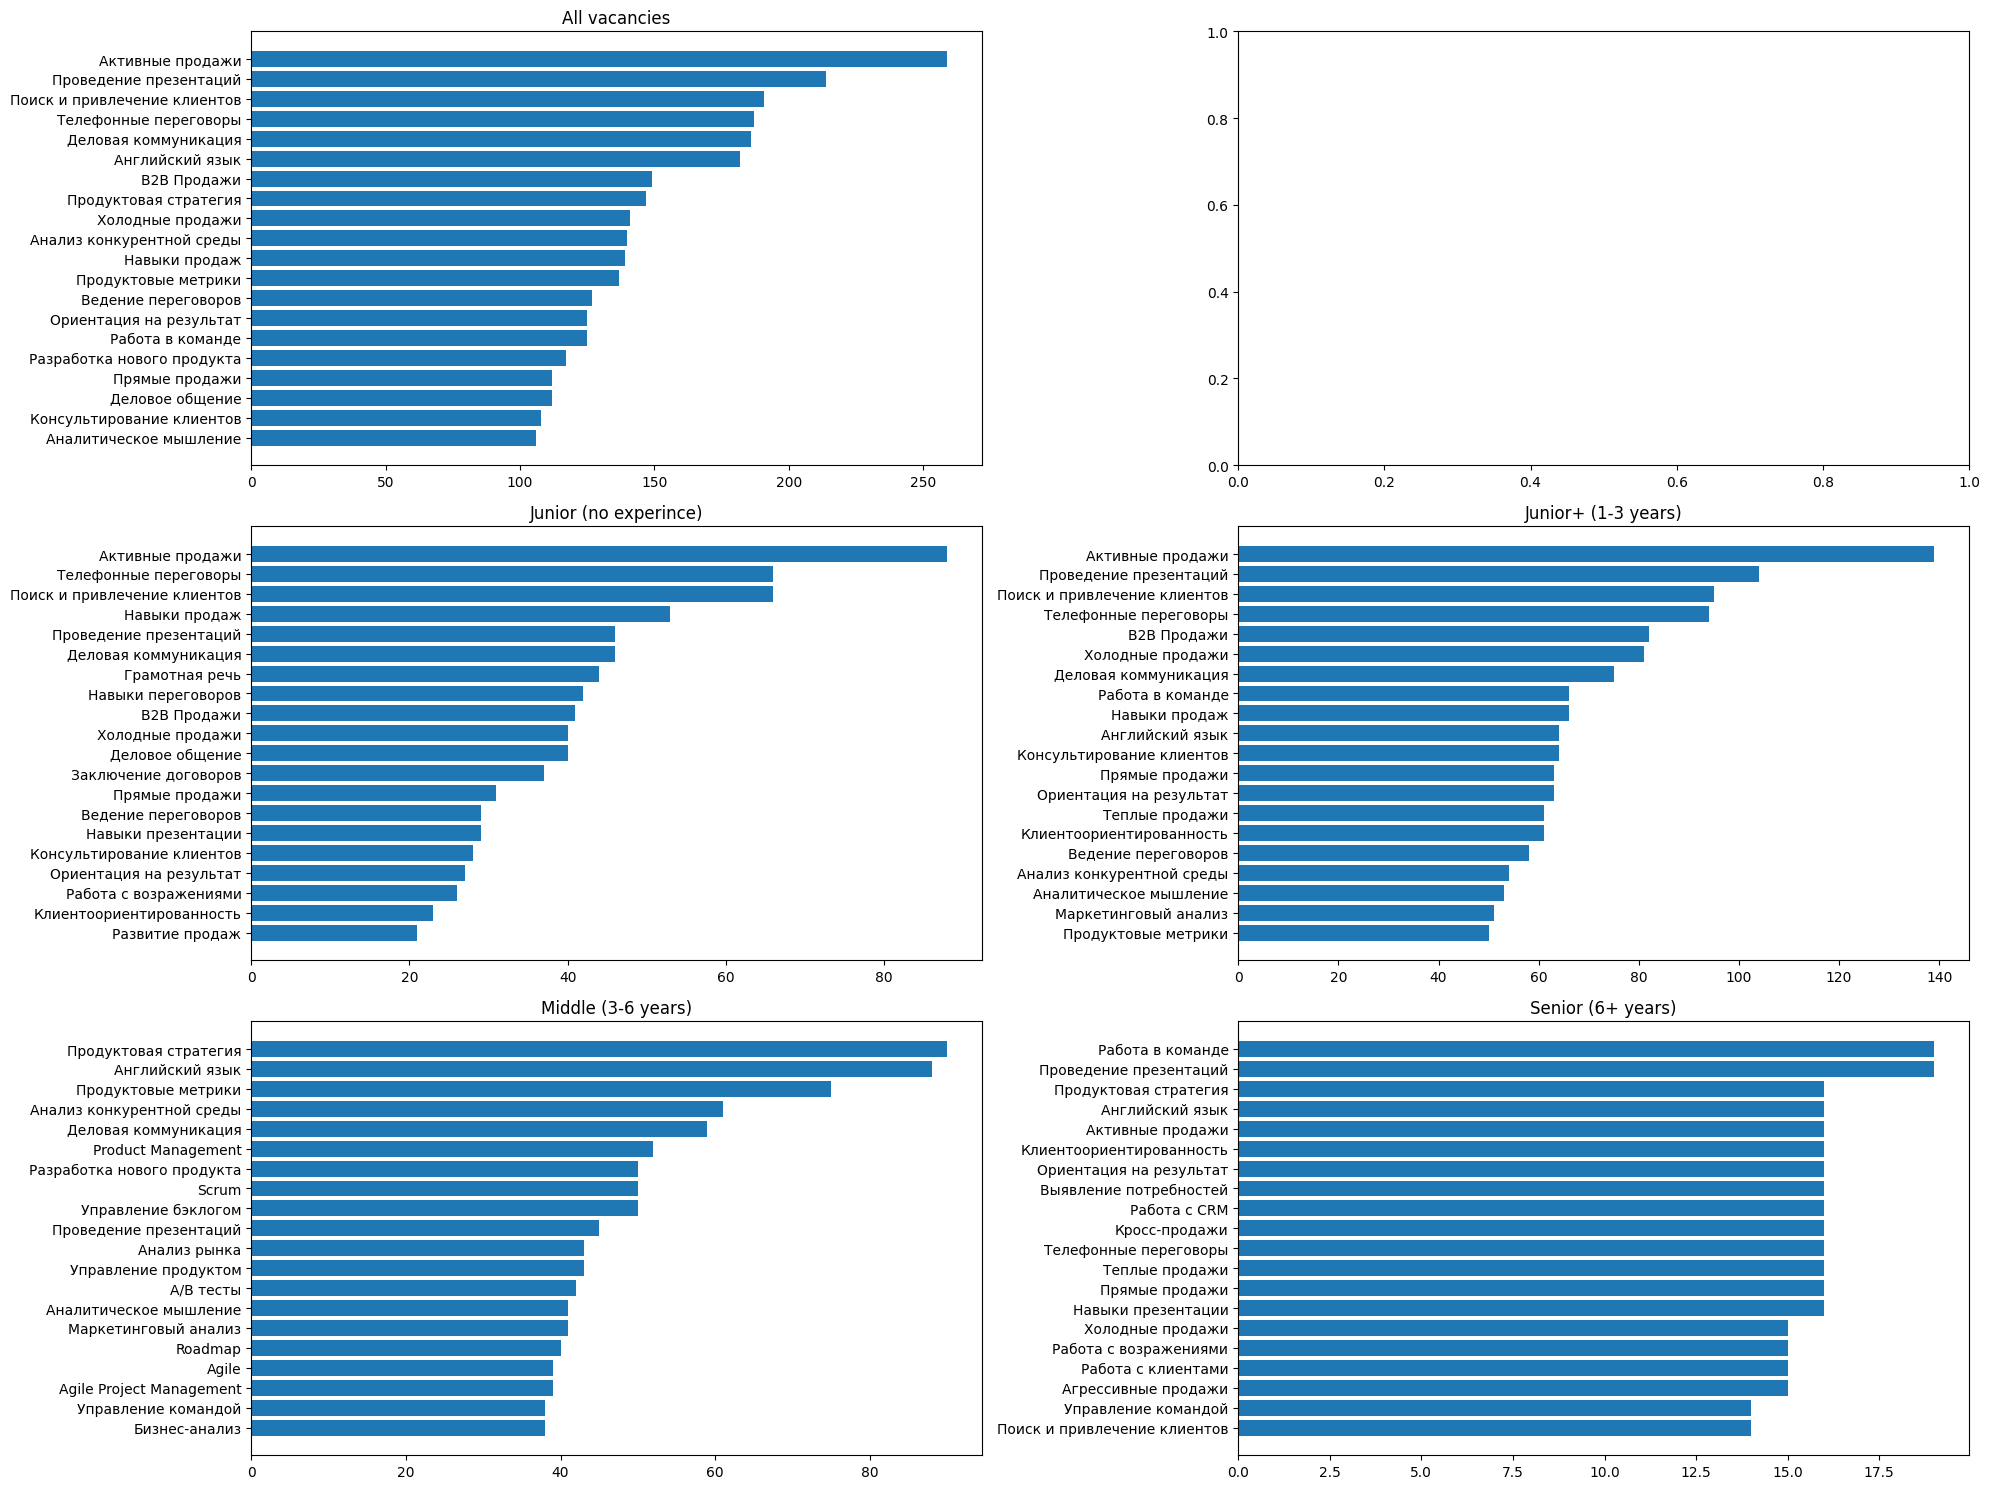

In [ ]:
analysis.show_skills()

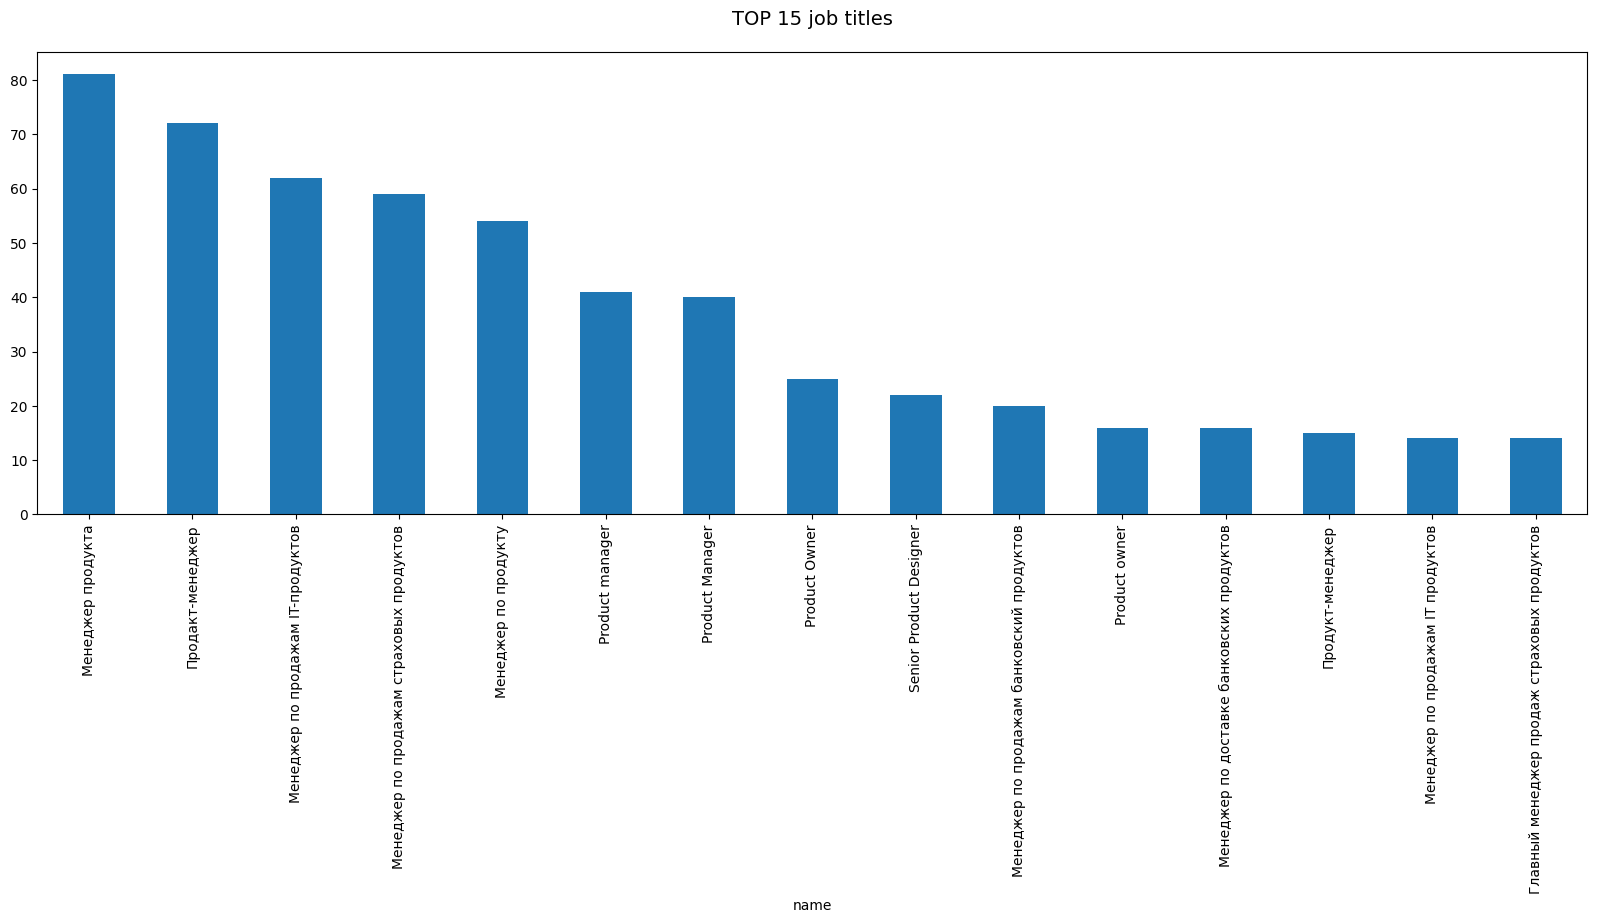

In [ ]:
analysis.show_job_titles(15)

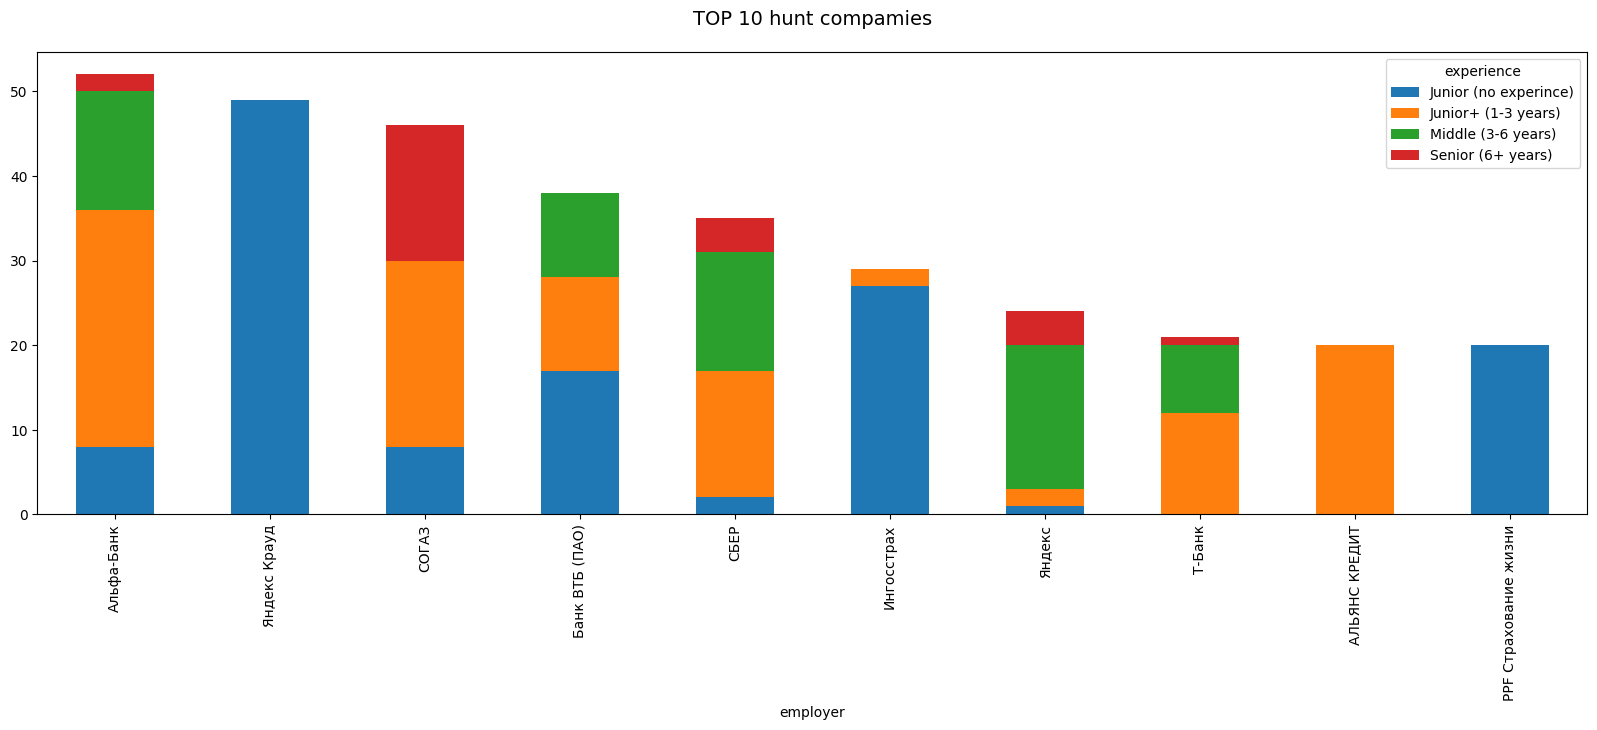

In [ ]:
analysis.show_companies(10)

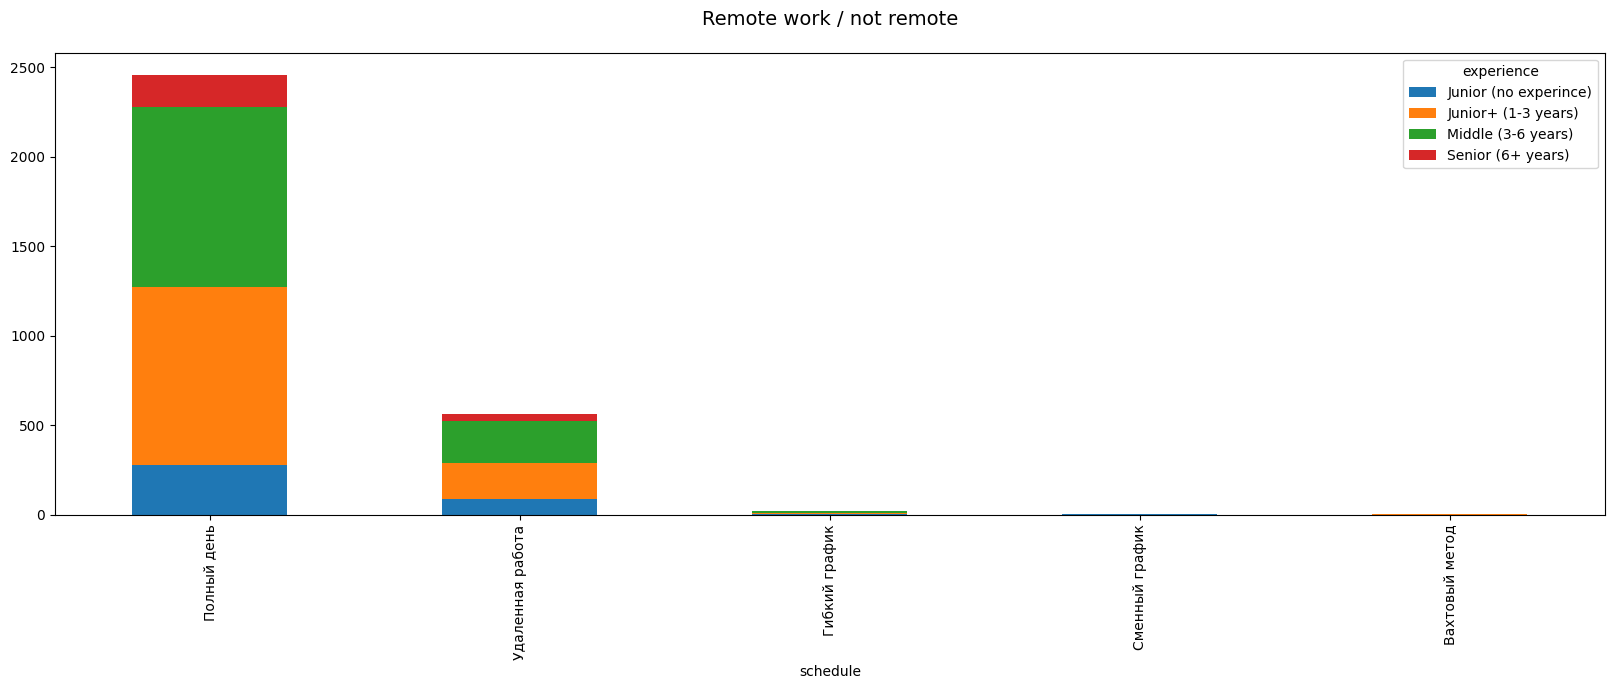

In [ ]:
analysis.show_shedule()

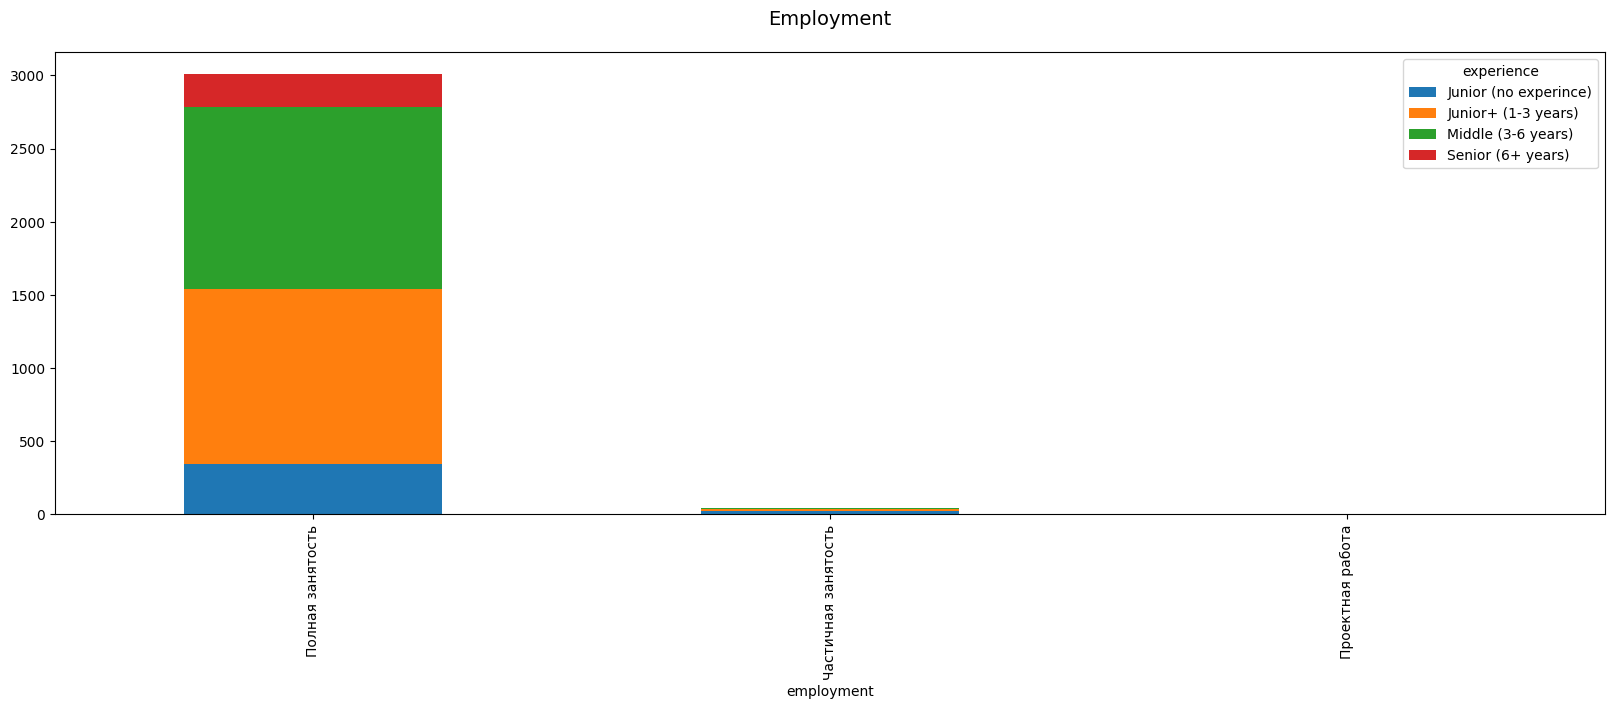

In [ ]:
analysis.show_employment()

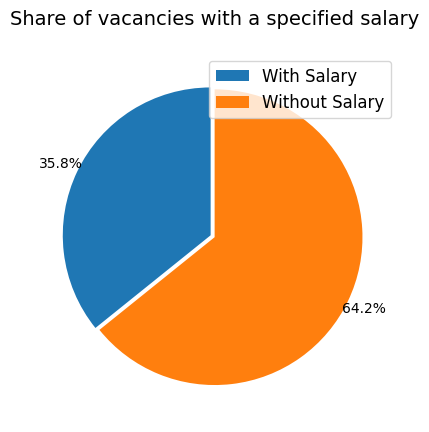

In [ ]:
analysis.show_salary()

<ipython-input-5-17444a37269d>:321: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([jun_salary, jun_plus_salary, middle_salary, senior_salary],


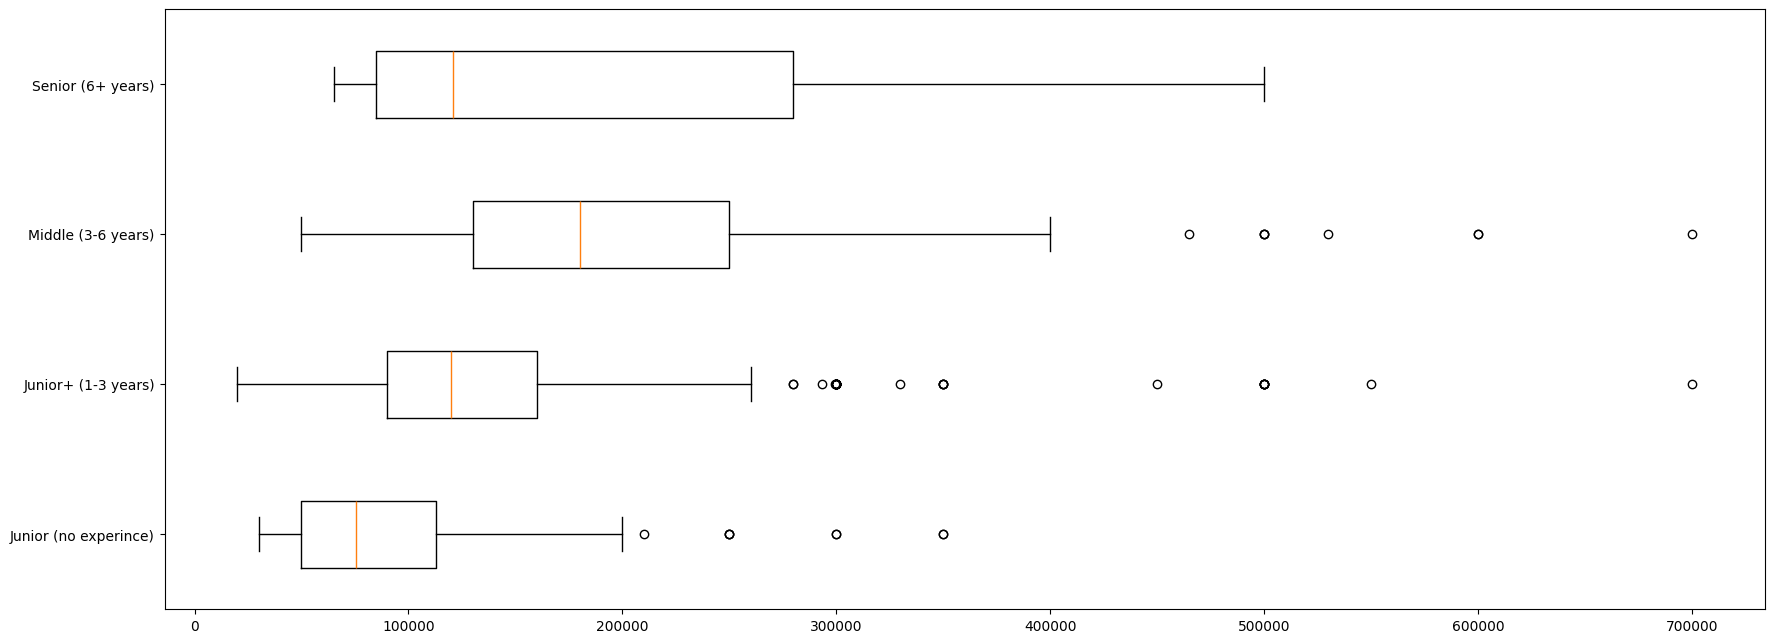

In [ ]:
analysis.show_salary_boxplot()

In [ ]:
analysis.download_csv()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>